In [1]:
from elasticsearch import Elasticsearch
from datetime import datetime as dt
import pandas as pd
import numpy as np
from csv import DictReader
import json
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

### PREPROCESAMIENTO

In [2]:
#DATOS_FW = 'Datos/Originales/FW_logs/log2.csv'
DATOS_FW = 'Datos/Transformados/log200.csv'
df=pd.read_csv(DATOS_FW)

In [3]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


#### Formato

In [4]:
# formato de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [3]:
# los puertos son indicadores unicos de cada nombre -> str

puertos=["Source Port", "Destination Port", "NAT Source Port","NAT Destination Port"]

df[puertos]=df[puertos].astype('object')

#### Missings

In [6]:
# missings 
df.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

#### Duplicados

In [7]:
# duplicados
df.duplicated().sum()
df['duplicado'] = df.duplicated()
df[df['duplicado'] == True]

# porque se mandan separados en la misma cantidad?
# error?


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,duplicado
268,21268,62609,0,0,deny,146,146,0,1,0,1,0,True
351,48706,23393,0,0,deny,60,60,0,1,0,1,0,True
593,65003,57470,0,0,deny,78,78,0,1,0,1,0,True
632,443,49988,0,0,deny,82,82,0,1,0,1,0,True
661,10669,49756,0,0,deny,60,60,0,1,0,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65517,54874,445,0,0,drop,70,70,0,1,0,1,0,True
65519,49784,445,0,0,drop,70,70,0,1,0,1,0,True
65521,42995,26467,0,0,deny,62,62,0,1,0,1,0,True
65522,53314,64097,0,0,deny,66,66,0,1,0,1,0,True


In [8]:
df[df['duplicado'] == True].groupby('Action').count()

# la mayoria son rechazados

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,duplicado
Action,,,,,,,,,,,,
allow,201,201,201,201,201,201,201,201,201,201,201,201
deny,6945,6945,6945,6945,6945,6945,6945,6945,6945,6945,6945,6945
drop,1216,1216,1216,1216,1216,1216,1216,1216,1216,1216,1216,1216


#### Outliers

In [9]:
df.describe()

# hay vaores muy elevados en los maximos 


,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [10]:
df.sort_values('Bytes').tail(10)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,duplicado
57556,51779,3389,21341,3389,allow,62242217,4119315,58122902,123738,4772,43917,79821,False
58370,51145,80,27456,80,allow,78198970,2041652,76157318,79332,368,28698,50634,False
48412,49006,443,37569,443,allow,119425284,929428,118495856,93687,498,9675,84012,False
23851,63996,443,19057,443,allow,122293139,3727246,118565893,125460,331,39649,85811,False
47827,60211,443,55686,443,allow,126490514,2726981,123763533,123275,553,41466,81809,False
33967,15503,62336,46736,62336,allow,127653507,122661116,4992391,161030,2162,82907,78123,False
40689,59275,443,56019,443,allow,242735602,5306961,237428641,238334,3604,81340,156994,False
63595,50121,443,24047,443,allow,307104860,2750998,304353862,234597,6122,15017,219580,False
61429,15792,3478,30536,3478,allow,428935914,213443641,215492273,635946,2242,308738,327208,False
10220,57235,15187,23276,15187,allow,1269359015,948477220,320881795,1036116,9283,747520,288596,False


In [11]:
df.sort_values('Elapsed Time (sec)').tail(10)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,duplicado
41885,58705,5228,47511,5228,allow,4706,2850,1856,44,6872,25,19,False
48288,35461,5228,26150,5228,allow,8648,2111,6537,40,7038,21,19,False
56933,34734,443,41689,443,allow,7974,2716,5258,50,7261,26,24,False
64876,30188,36914,20864,36914,allow,2668,1950,718,16,7827,14,2,False
29876,56766,443,14480,443,allow,10137,4019,6118,42,8169,24,18,False
42324,59314,443,58564,443,allow,16862,7584,9278,97,8912,60,37,False
34383,57239,5228,64844,5228,allow,16135,7514,8621,173,9115,72,101,False
10220,57235,15187,23276,15187,allow,1269359015,948477220,320881795,1036116,9283,747520,288596,False
1675,44246,5228,57956,5228,allow,19678,4762,14916,98,9851,54,44,False
18759,49165,5938,24586,5938,allow,143727,72050,71677,1106,10824,655,451,False


#### Analisis exploratorio

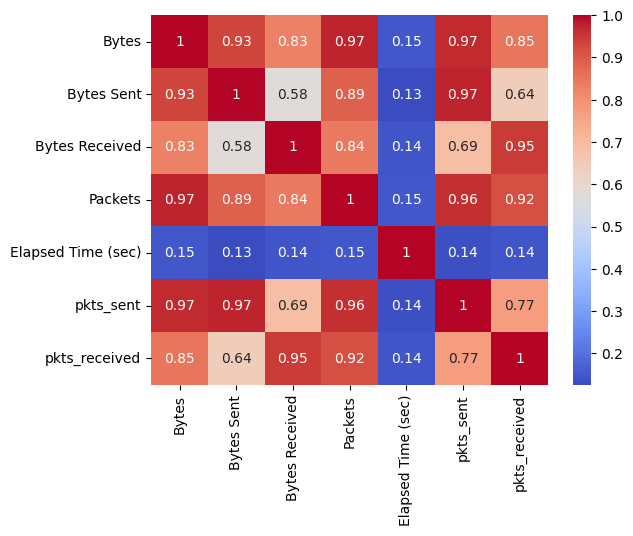

In [16]:
# CORRELACIONES

corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr(method='pearson')

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

# Muestra el mapa de calor
plt.show()

# Correlaciones altas en los datos de envio de bits y paquetes 
# Elapsed time poca correlacion con las variables


In [12]:
# relacion entre elapsed time y pkts sent

fig=px.scatter(x=df['Elapsed Time (sec)'], y=df['pkts_sent'])
fig.show()

In [13]:
# media por action

df.groupby('Action').mean()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,duplicado
Action,,,,,,,,,,,,
allow,51127.933103,4728.336265,33549.797689,4648.409724,169037.953241,38917.411743,130120.541498,178.348565,114.617349,71.334883,107.013682,0.005340
deny,38557.289317,33904.072129,31.828184,2.164142,83.211717,83.036098,0.175619,1.003270,0.000133,1.002202,0.001068,0.463402
drop,57038.209244,445.0,0.0,0.0,68.675278,68.675278,0.000000,1.000000,0.000000,1.000000,0.000000,0.094623
reset-both,26722.425926,24882.333333,6673.648148,753.111111,157.351852,141.796296,15.555556,1.666667,0.129630,1.444444,0.222222,0.000000


In [14]:
df[df['Action']=='drop']
# cuando nat es 0 es porque no cambia el puerto

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,duplicado
141,51048,445,0,0,drop,70,70,0,1,0,1,0,False
142,51045,445,0,0,drop,70,70,0,1,0,1,0,False
145,55725,445,0,0,drop,70,70,0,1,0,1,0,False
146,55723,445,0,0,drop,70,70,0,1,0,1,0,False
147,55724,445,0,0,drop,70,70,0,1,0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65519,49784,445,0,0,drop,70,70,0,1,0,1,0,True
65520,49783,445,0,0,drop,70,70,0,1,0,1,0,False
65529,54871,445,0,0,drop,70,70,0,1,0,1,0,False
65530,54870,445,0,0,drop,70,70,0,1,0,1,0,False


In [19]:
df[df['Action']=='deny'] # con deny pasa lo mismo

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,duplicado
143,13394,23,0,0,deny,60,60,0,1,0,1,0,False
144,61078,57470,0,0,deny,62,62,0,1,0,1,0,False
156,62776,62413,0,0,deny,146,146,0,1,0,1,0,False
158,46448,30170,0,0,deny,159,159,0,1,0,1,0,False
159,10688,25174,0,0,deny,146,146,0,1,0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65518,54013,37965,0,0,deny,66,66,0,1,0,1,0,False
65521,42995,26467,0,0,deny,62,62,0,1,0,1,0,True
65522,53314,64097,0,0,deny,66,66,0,1,0,1,0,True
65523,55142,26467,0,0,deny,66,66,0,1,0,1,0,False


### Anomalias

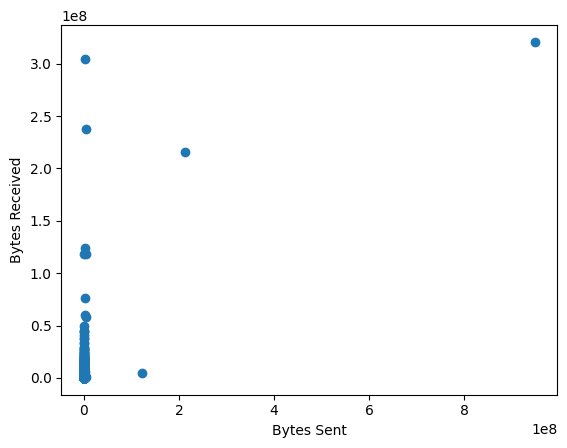

In [20]:
# Crea un gráfico de dispersión de Bytes Sent vs. Bytes Received
plt.scatter(df['Bytes Sent'], df['Bytes Received'])
plt.xlabel('Bytes Sent')
plt.ylabel('Bytes Received')
plt.show()

<Axes: >

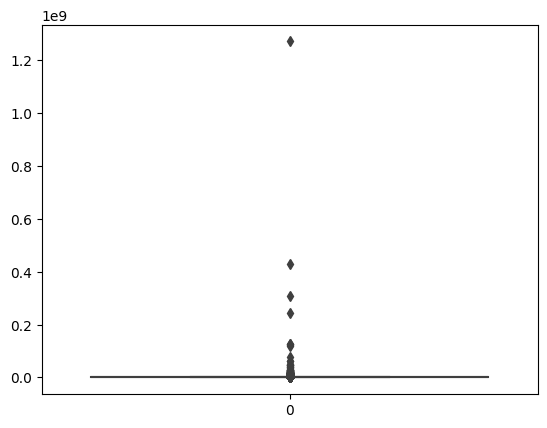

In [22]:
# Crea un boxplot de la variable Bytes
sns.boxplot(data=df['Bytes'])

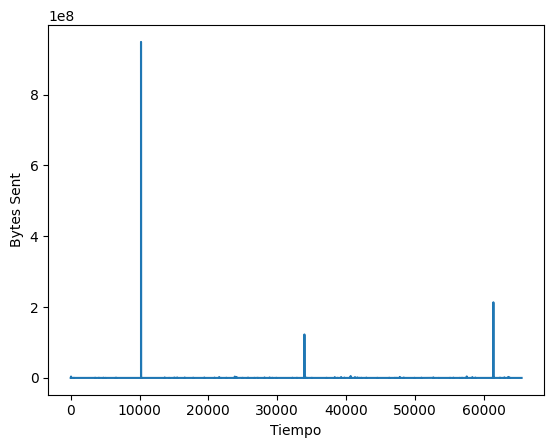

In [23]:
# Crea un gráfico de líneas de la variable Bytes Sent
plt.plot(df['Bytes Sent'])
plt.xlabel('Tiempo')
plt.ylabel('Bytes Sent')
plt.show()

<Axes: xlabel='Bytes Received', ylabel='Action'>

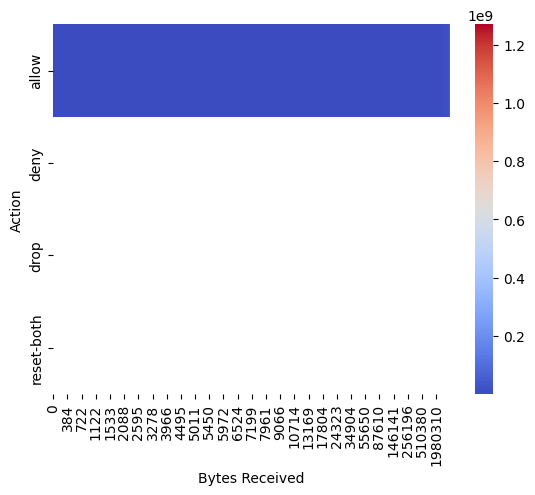

In [25]:
# Crea un heatmap de Bytes vs. Action
sns.heatmap(df.pivot_table(values='Bytes', index='Action', columns='Bytes Received'), cmap='coolwarm')

In [34]:
# columnas numericas
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

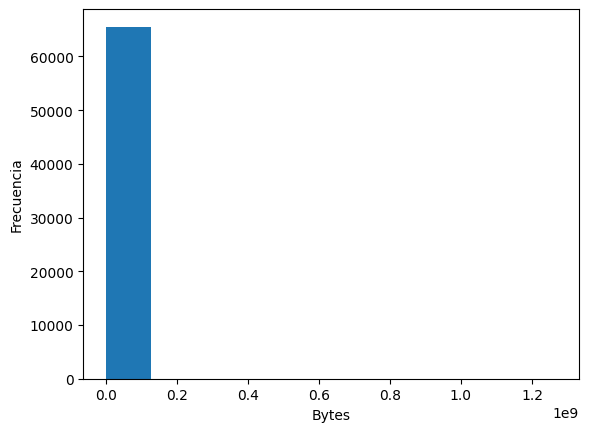

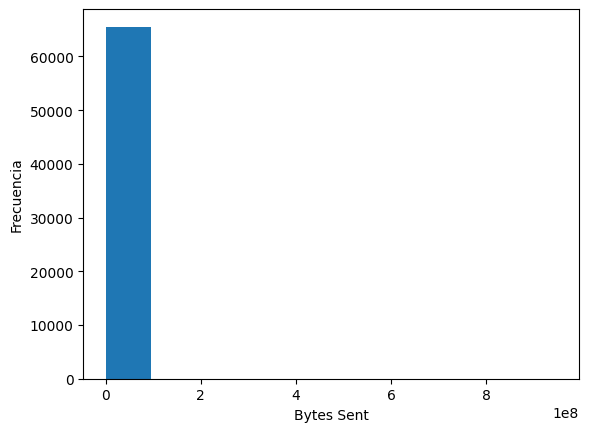

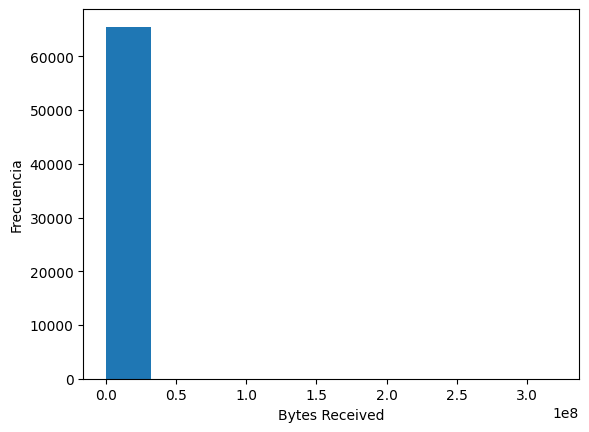

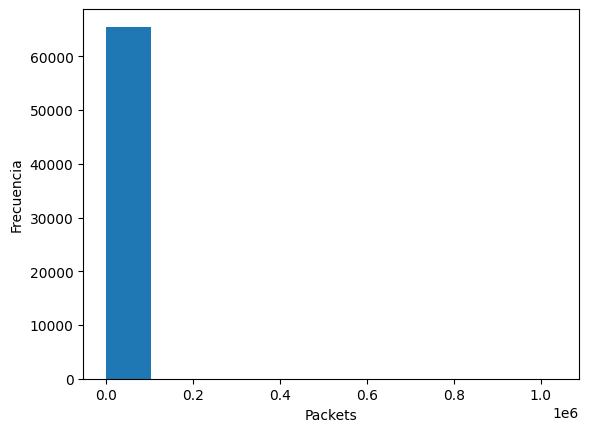

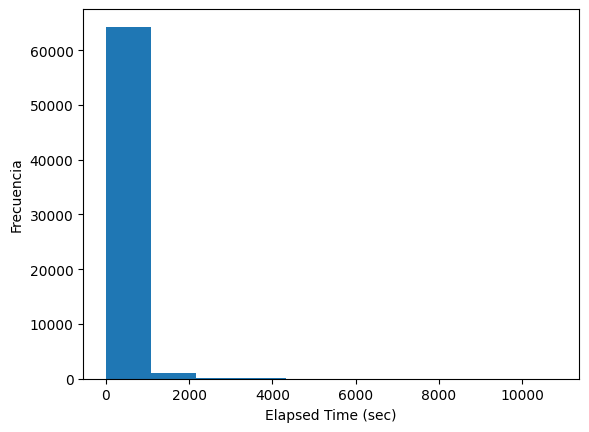

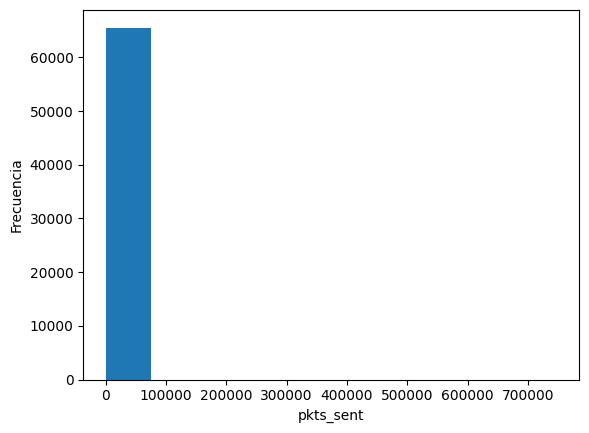

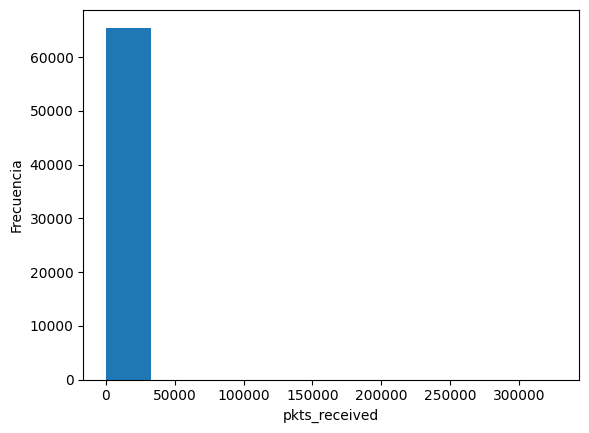

In [42]:
for i in numeric_cols:
    plt.hist(df[i], bins=10)
    plt.xlabel(i)
    plt.ylabel('Frecuencia')
    plt.show()

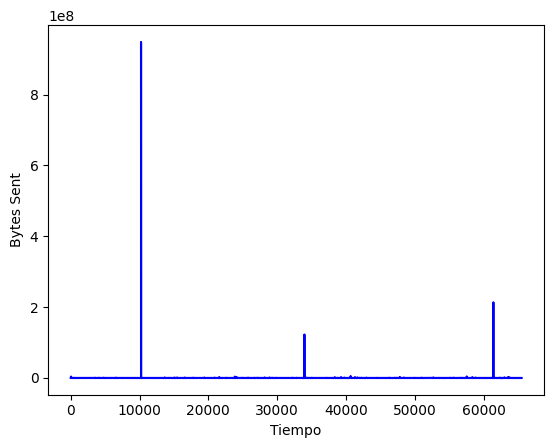

In [28]:
# Crea un gráfico de área de la variable Bytes Sent
plt.fill_between(df.index, df['Bytes Sent'], color='blue', alpha=0.2)
plt.plot(df['Bytes Sent'], color='blue')
plt.xlabel('Tiempo')
plt.ylabel('Bytes Sent')
plt.show()

In [47]:
# DESVIACIONES ESTANDAR

std_bytes_sent = [df[i].std() for i in numeric_cols]
std_bytes_sent

[5618438.909050969,
 3828138.6497874884,
 2463207.7118836874,
 5133.0023461227765,
 302.46176230092357,
 3218.871288079454,
 2223.332271443683]

In [48]:
# IDENTIFICAR ANOMALIAS SEGUN DESVIACION ESTANDAR

# Calcular la media y la desviación estándar de cada variable numérica
means = df.select_dtypes(include='number').mean()
stds = df.select_dtypes(include='number').std()

# Crear una lista para almacenar las etiquetas de anomalía
anomaly_labels = []

# Iterar por cada fila en el conjunto de datos
for index, row in df.iterrows():

    # Verificar si los valores numéricos de la fila se desvían demasiado de la media
    is_anomaly = False
    for column in df.select_dtypes(include='number').columns:
        if abs(row[column] - means[column]) > 3 * stds[column]:  # Usamos 3 desviaciones estandar como umbral
            is_anomaly = True
            break

    # Agregar la etiqueta de anomalía a la lista
    anomaly_labels.append('anomaly' if is_anomaly else 'normal')

# Agregar la columna de etiquetas de anomalía al conjunto de datos
df['anomaly'] = anomaly_labels

In [50]:
df.groupby('anomaly').size()

anomaly
anomaly     1407
normal     64125
dtype: int64

In [ ]:
# TEST DE NORMALIDAD PARA VER SI ALGUNA DE LAS VARIABLES ES NORMAL

In [15]:
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

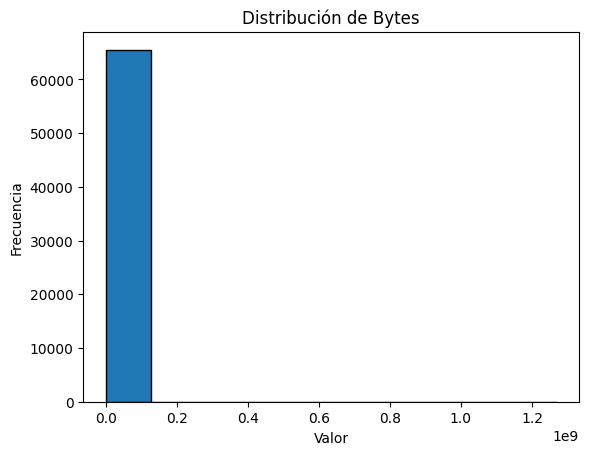

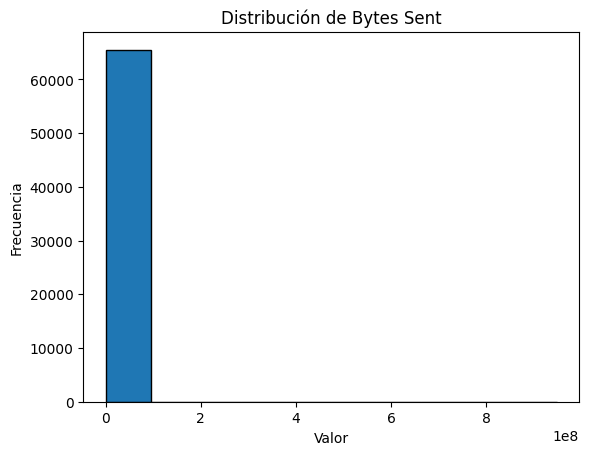

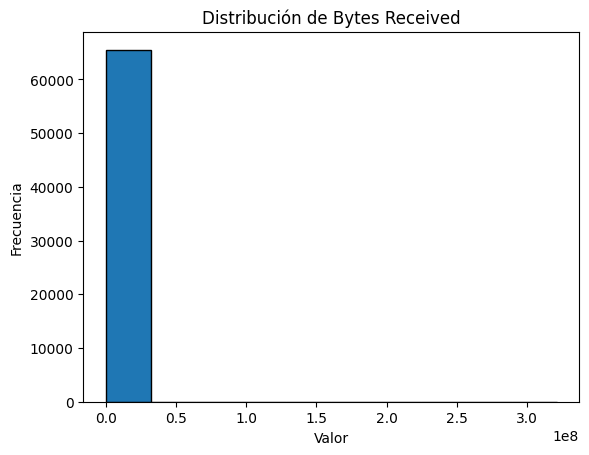

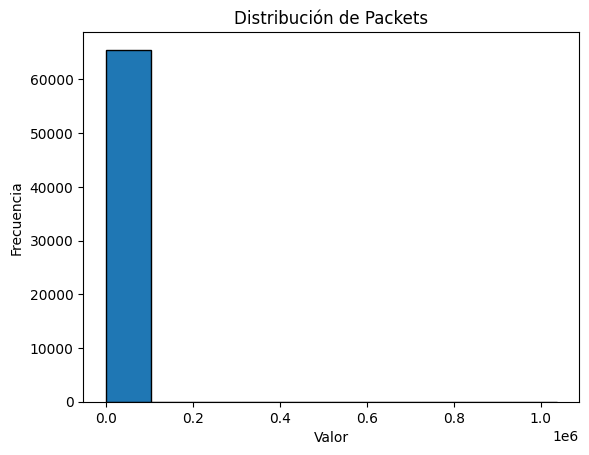

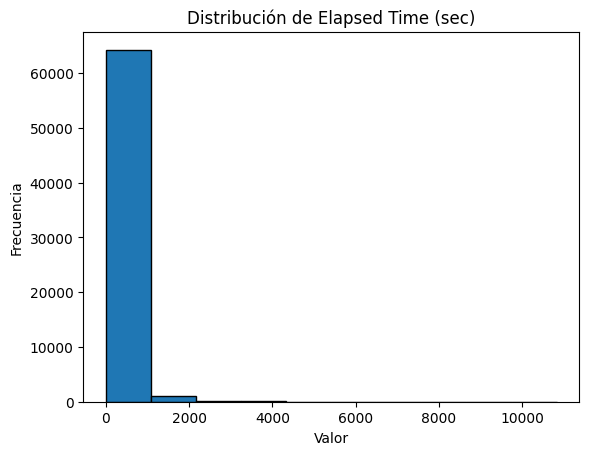

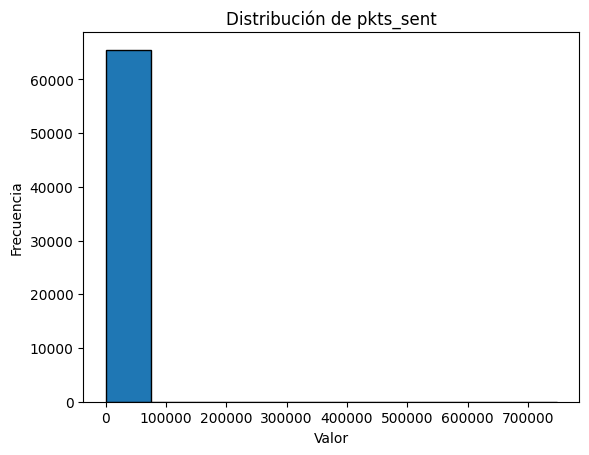

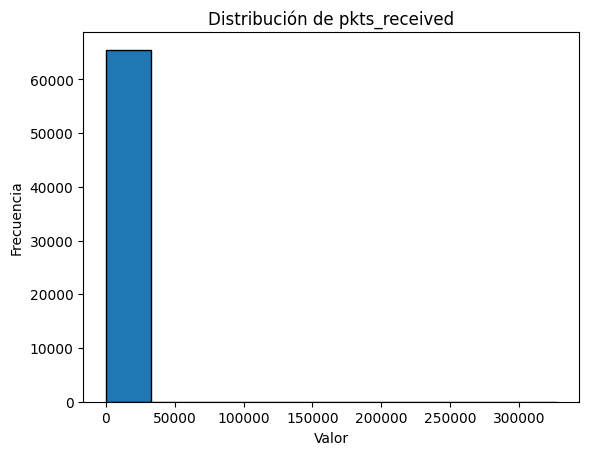

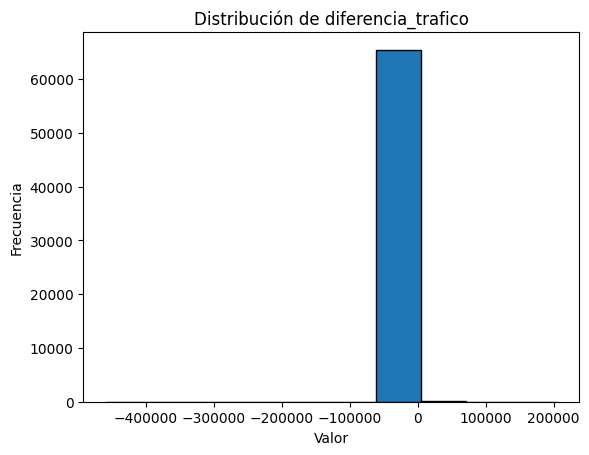

In [16]:
for columna in numeric_cols:
    plt.figure()  # Crear una nueva figura para cada gráfico
    df[columna].plot(kind='hist', edgecolor='black')  # Utilizar histograma como ejemplo

    # Personalizar el gráfico
    plt.title('Distribución de {}'.format(columna))
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

# Mostrar los gráficos
plt.show()

In [11]:
import scipy.stats as stats

def is_normal(data, alpha=0.05):
    """
    Verifica si una variable sigue una distribución normal utilizando la prueba de Shapiro-Wilk.
    
    :param data: array-like, una variable de un conjunto de datos
    :param alpha: float, el nivel de significación para la prueba
    :return: bool, True si la variable sigue una distribución normal, False de lo contrario
    """
    stat, p = stats.shapiro(data)
    if p > alpha:
        return "distribucion normal"
    else:
        return "distribucion no normal"

In [12]:
for i in numeric_cols:
    print(i+ " " + str(is_normal(df[i])))

Bytes distribucion no normal
Bytes Sent distribucion no normal
Bytes Received distribucion no normal
Packets distribucion no normal
Elapsed Time (sec) distribucion no normal
pkts_sent distribucion no normal
pkts_received distribucion no normal


In [6]:
from scipy.stats import kstest
import numpy as np

def normality_test_ks(data, alpha=0.05):
    """
    Prueba de normalidad utilizando la prueba de Kolmogorov-Smirnov (KS).

    Parámetros:
    -----------
    data: array-like
        Los datos a ser analizados.

    alpha: float, optional (default=0.05)
        Nivel de significancia para la prueba estadística.

    Returns:
    --------
    normality: bool
        True si los datos parecen seguir una distribución normal, False en caso contrario.

    """
    # Asumimos que la muestra sigue una distribución normal
    mu, sigma = np.mean(data), np.std(data)
    normal_data = (data - mu) / sigma

    # Realizamos la prueba de KS
    stat, p_value = kstest(normal_data, 'norm')

    # Evaluamos el resultado de la prueba
    if p_value > alpha:
        return "distribucion normal"
    else:
        return "distribucion no normal"

In [14]:
for i in numeric_cols:
    print(i+ " " + str(normality_test_ks(df[i])))

Bytes distribucion no normal
Bytes Sent distribucion no normal
Bytes Received distribucion no normal
Packets distribucion no normal
Elapsed Time (sec) distribucion no normal
pkts_sent distribucion no normal
pkts_received distribucion no normal


In [ ]:
# LOS DOS DAN QUE NINGUNA VARIABLE ES NORMAL POR LO QUE NO SE UTILIZARA EL METODO DE LA DESVIACION ESTANDAR PARA IDENTIFICAR ANOMALIAS

In [15]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, auc

def find_optimal_threshold(dataset):
    # Extraer las variables numéricas
    numeric_data = dataset.select_dtypes(include=[np.number])
    num_columns = numeric_data.columns

    # Estimar la densidad de las variables numéricas
    kde_models = {}
    for column in num_columns:
        kde = KernelDensity(bandwidth=0.2).fit(numeric_data[[column]])
        kde_models[column] = kde
    
    # Calcular la densidad de las observaciones
    densities = np.zeros(len(dataset))
    for column in num_columns:
        kde = kde_models[column]
        densities += kde.score_samples(numeric_data[[column]])
    
    # Calcular la curva ROC para diferentes valores de umbral
    fpr, tpr, thresholds = roc_curve(dataset['anomalia'], -densities)
    roc_auc = auc(fpr, tpr)

    # Encontrar el umbral óptimo según la curva ROC
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [16]:
find_optimal_threshold(df)

In [19]:
np.nan_to_num()

In [22]:
import numpy as np
from sklearn.metrics import roc_curve, auc

def find_optimal_threshold_iqr(dataset):
    # Extraer las variables numéricas
    numeric_data = dataset.select_dtypes(include=[np.number])
    num_columns = numeric_data.columns

    # Calcular el rango intercuartílico (IQR) de las variables numéricas
    iqr = numeric_data.quantile(0.75) - numeric_data.quantile(0.25)

    # Calcular la curva ROC para diferentes valores de umbral
    # densities = -(numeric_data - numeric_data.median()) / iqr
    # densities = densities.sum(axis=1)
    # densities=np.nan_to_num(densities)
    densities = np.zeros(len(dataset))
    for column in num_columns:
        kde = kde_models[column]
        column_density = kde.score_samples(numeric_data[[column]])
        column_density = np.nan_to_num(column_density, nan=0, posinf=1e15, neginf=-1e15)
        densities += column_density
    fpr, tpr, thresholds = roc_curve(dataset['anomalia'], densities)
    roc_auc = auc(fpr, tpr)

    # Encontrar el umbral óptimo según la curva ROC
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [2]:
import numpy as np
from sklearn.neighbors import KernelDensity

def kde_density_estimation(dataset):
    # Extraer las variables numéricas

    # Estimar la densidad de las variables numéricas

    kde = KernelDensity(bandwidth=0.2).fit(dataset['Bytes'])

    return kde

In [7]:
densities = np.zeros(len(df))
densities

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
from sklearn.metrics import roc_curve, auc

def find_optimal_threshold(dataset):
    # Estimar la densidad de las variables numéricas
    kde = kde_density_estimation(dataset)
    print(kde)

    # Calcular la densidad de las observaciones
    column_density = kde.score_samples(dataset[['Bytes']])
    column_density = np.nan_to_num(column_density, nan=0, posinf=1e15, neginf=-1e15)
    
    
    # Calcular la curva ROC para diferentes valores de umbral
    fpr, tpr, thresholds = roc_curve(dataset['anomalia'], -column_density)
    roc_auc = auc(fpr, tpr)

    # Encontrar el umbral óptimo según la curva ROC
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [11]:
find_optimal_threshold(df[['Bytes', 'anomalia']])

ValueError: Expected 2D array, got 1D array instead:
array=[ 177. 4768.  238. ...   70.   70.   70.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Creacion de variables

In [12]:
# variable de trafico , si los packetes recividos son mayores a los enviados

df['trafico']=df['pkts_received'] > df['pkts_sent']

df['trafico'] = np.where(df['trafico'], 'superior', 'inferior')

In [81]:
df.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received', 'trafico', 'diferencia_trafico', 'anomalia'],
      dtype='object')

In [115]:
# diferencia de paquetes enviados y recividos

df['diferencia_trafico']=df['Bytes Received']-df['Bytes Sent']

In [ ]:
# DETECTAR ANOALIAS CON ESTAS 3

# Bytes: La variable "Bytes" es importante porque representa la cantidad total de datos transferidos a través del firewall. Cambios inusuales en esta métrica pueden indicar actividades sospechosas, como ataques de exfiltración de datos o descargas masivas. Observar las anomalías en la cantidad de bytes puede proporcionar una indicación sólida de posibles violaciones de seguridad o comportamientos anómalos.

# Packets: La variable "Packets" es relevante ya que se refiere al número total de paquetes de red procesados por el firewall. La detección de cambios significativos en la cantidad de paquetes puede ser útil para identificar patrones de tráfico anormales, como ataques de denegación de servicio (DDoS) o intentos de escaneo de puertos. Los picos repentinos en la cantidad de paquetes podrían indicar actividades maliciosas o inesperadas en la red.


In [ ]:
# ANALISIS:
# 1- observar la media y mediana de las variables e histogramas
# 2- se puede agrupar por puerto origen y puerto destino y el rango intercualrtilico de cada grupo
# 3- rango intercuartilico por 3 sinmas
# 4- 

In [125]:
# marcar anomalia si el valor de alguna variable esta por encima del valor intercuartlico

#columnas=['Bytes', 'Bytes Sent','Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent','pkts_received']
columnas=['pkts_sent']
# Calcula el IQR para cada columna numérica
Q1 = df[columnas].quantile(0.1)
Q3 = df[columnas].quantile(0.9)
IQR = Q3 - Q1

# Define el umbral para identificar outliers
umbral = 1.5

# Crea una nueva columna en el dataframe para indicar si algún valor es outlier
outliers = ((df[columnas] < (Q1 - umbral * IQR)) | (df[columnas] > (Q3 + umbral * IQR))).any(axis=1)
df['anomalia'] = outliers

df['anomalia'] = np.where(df['anomalia'], 1, 0)

In [3]:
df.groupby('anomalia').size()

anomalia
0    61215
1     4317
dtype: int64

3168.9000000000015
8136.750000000004
-5110.850000000002


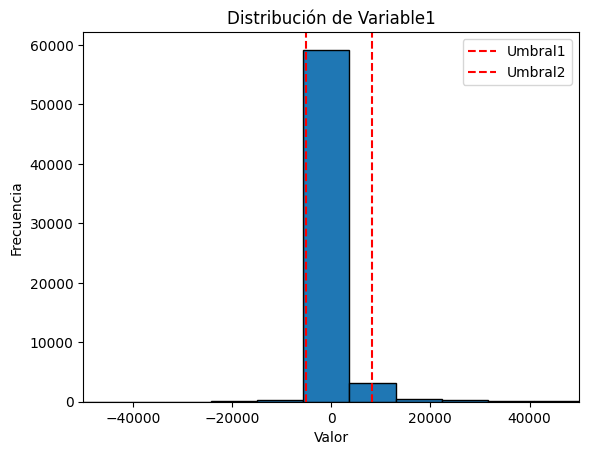

In [133]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['diferencia_trafico'].quantile(0.1)
Q3 = df['diferencia_trafico'].quantile(0.9)
print(Q3)
IQR = Q3 - Q1

# Calcular el umbral para identificar outliers
umbral1 = Q3 + 1.5 * IQR
umbral2 = Q1 - 1.5 * IQR
print(umbral1)
print(umbral2)

# Crear el histograma
plt.hist(df['diferencia_trafico'], bins=100000, edgecolor='black')

# Agregar la línea horizontal del umbral
plt.axvline(x=umbral1, color='r', linestyle='--', label='Umbral1')
plt.axvline(x=umbral2, color='r', linestyle='--', label='Umbral2')
plt.xlim(-50000, 50000)
# Personalizar el gráfico
plt.title('Distribución de Variable1')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

In [64]:
df['diferencia_trafico']

0           0
1          -1
2           0
3          -1
4           5
         ... 
65527      -2
65528    2705
65529      -1
65530      -1
65531      -1
Name: diferencia_trafico, Length: 65532, dtype: int64

In [129]:
df['pkts_sent'].min()

1

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7f9c851850>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7f9c851d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7f9c8515b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7f9c85b310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7f9c85b5b0>],
 'means': []}

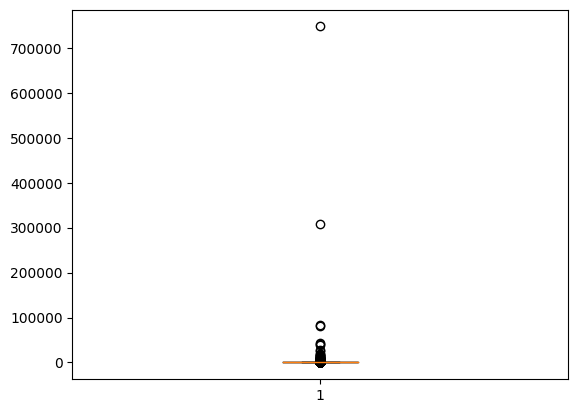

In [67]:
plt.boxplot(df['pkts_sent'])

In [137]:
def anomalias(df):
    # Calcula el IQR para cada columna numérica
    Q1_dif = df['diferencia_trafico'].quantile(0.1)
    Q3_dif = df['diferencia_trafico'].quantile(0.9)
    Q1_pkt = df['pkts_sent'].quantile(0.1)
    Q3_pkt = df['pkts_sent'].quantile(0.9)
    IQR_dif = Q3_dif - Q1_dif
    IQR_pkt = Q3_pkt - Q1_pkt

    # Define el umbral para identificar outliers
    umbral_dif = 1.5
    umbral_pkt = 1.5

    # Crea una nueva columna en el dataframe para indicar si algún valor es outlier
    outliers = ((df['diferencia_trafico'] < (Q1_dif - umbral_dif * IQR_dif)) | (df['diferencia_trafico'] > (Q3_dif + umbral_dif * IQR_dif)) |  (df['pkts_sent'] > (Q3_pkt + umbral_pkt * IQR_pkt)))
    df['anomalia'] = outliers

    df['anomalia'] = np.where(df['anomalia'], 1, 0)
    return df

In [138]:
df=anomalias(df)

In [139]:
df.groupby('anomalia').size()

anomalia
0    61523
1     4009
dtype: int64

In [19]:
df=df.drop('duplicado', axis=1)

In [20]:
df.to_csv('DATOS/TRANSFORMADOS/log2.csv', index=False)

In [28]:
df.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received', 'trafico', 'diferencia_trafico', 'anomalia'],
      dtype='object')

### Creamos la conexion con elastic

In [21]:
DATOS_FW='DATOS/TRANSFORMADOS/log2.csv'

In [22]:
keyfile = '.pwd.json'
with open(keyfile, 'r') as f:
  credentials = json.load(f)

ELASTIC_PASSWORD = credentials.get("contrasena_elastic")

In [23]:
client = Elasticsearch(
    "https://localhost:9200",
    ca_certs="/home/reto08/elasticsearch-8.7.0/config/certs/http_ca.crt",
    basic_auth=("elastic", ELASTIC_PASSWORD)
)

client.info()

ObjectApiResponse({'name': 'reto08-VirtualBox', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'MUJlYirJTmuSksVWKFD0uw', 'version': {'number': '8.7.0', 'build_flavor': 'default', 'build_type': 'tar', 'build_hash': '09520b59b6bc1057340b55750186466ea715e30e', 'build_date': '2023-03-27T16:31:09.816451435Z', 'build_snapshot': False, 'lucene_version': '9.5.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

### Comenzamos con la subida de los datos transformados

In [24]:
with open(DATOS_FW, 'r') as fichero:
    csv_dict = DictReader(fichero)
    indice = 1
    numericas=['Bytes', 'Bytes Sent','Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'diferencia_trafico']
    strings=['Source Port', 'Destination Port', 'NAT Source Port','NAT Destination Port', 'Action','trafico', 'anomalia']

    for row in csv_dict:
        if indice <= 8000: # solo indexa 5 registros
            for num in numericas:
                row[num] = int(row[num])
            for let in strings:
                row[let]=str(row[let])
            
            resp = client.index(index = 'df_log', id = indice, document=row)
            indice = indice + 1

In [25]:
resp = client.search(index="df_log", body={"query": {"match_all": {}}})
indice1 = resp['hits']['total']['value']
print(f'Se han indexado {indice1} registros')

/tmp/ipykernel_4385/1839978308.py:1: DeprecationWarning:

The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.



Se han indexado 8000 registros


In [26]:
resp = client.get(index="df_log", id=1)
resp['_source']

{'Source Port': '57222',
 'Destination Port': '53',
 'NAT Source Port': '54587',
 'NAT Destination Port': '53',
 'Action': 'allow',
 'Bytes': 177,
 'Bytes Sent': 94,
 'Bytes Received': 83,
 'Packets': 2,
 'Elapsed Time (sec)': 30,
 'pkts_sent': 1,
 'pkts_received': 1,
 'trafico': 'inferior',
 'diferencia_trafico': 0,
 'anomalia': 'no_anomalia'}

### DATASET WIFI.LOG

In [33]:
filename = './Datos/Originales/wifitraps_anonimo.log'

In [45]:

# Leer el archivo de texto y almacenar las líneas en una lista
with open(filename, 'r') as archivo:
    lineas = archivo.readlines()

# Crear una lista de diccionarios para almacenar los campos
campos = []

# Procesar cada línea del archivo
for linea in lineas:
    # Dividir la línea en pares de clave y valor
    pares = linea.strip().split(',')

    # Crear un diccionario para cada campo y agregarlo a la lista de campos
    campo = {}
    for par in pares:
        if '=' not in par:
            continue  # Omitir pares sin el símbolo '='

        clave_valor = par.strip().split('=', 1)
        if len(clave_valor) != 2:
            continue  # Omitir pares sin una clave o valor válido

        clave, valor = clave_valor
        campo[clave.strip()] = valor.strip()
    campos.append(campo)

# Crear el DataFrame a partir de la lista de campos
df = pd.DataFrame(campos)

In [31]:
def preprocesamiento_wifi(RUTA):

    # Leer el archivo de texto y almacenar las líneas en una lista
    with open(RUTA, 'r') as archivo:
        lineas = archivo.readlines()

    # Crear una lista de diccionarios para almacenar los campos
    campos = []

    # Procesar cada línea del archivo
    for linea in lineas:
        # Dividir la línea en pares de clave y valor
        pares = linea.strip().split(',')

        # Crear un diccionario para cada campo y agregarlo a la lista de campos
        campo = {}
        for par in pares:
            if '=' not in par:
                continue  # Omitir pares sin el símbolo '='

            clave_valor = par.strip().split('=', 1)
            if len(clave_valor) != 2:
                continue  # Omitir pares sin una clave o valor válido

            clave, valor = clave_valor
            campo[clave.strip()] = valor.strip()
        campos.append(campo)

    # Crear el DataFrame a partir de la lista de campos
    df = pd.DataFrame(campos)
    df = df.drop(df.columns[-1], axis=1)
    return df

In [34]:
df=preprocesamiento_wifi(filename)

In [4]:
df.shape

(49997, 10)

In [5]:
df.columns

Index(['DISMAN-EVENT-MIB::sysUpTimeInstance', 'SNMPv2-MIB::snmpTrapOID.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.1.0',
       'SNMPv2-SMI::enterprises.9.9.513.1.1.1.1.5.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.8.0',
       'SNMPv2-SMI::enterprises.9.9.513.1.2.1.1.1.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.10.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.27.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.28.0', 'm$[0C'],
      dtype='object')

In [35]:
df.head()

,DISMAN-EVENT-MIB::sysUpTimeInstance,SNMPv2-MIB::snmpTrapOID.0,SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.1.0,SNMPv2-SMI::enterprises.9.9.513.1.1.1.1.5.0,SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.8.0,SNMPv2-SMI::enterprises.9.9.513.1.2.1.1.1.0,SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.10.0,SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.27.0,SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.28.0,m$[0C
0,5:2:05:55.00,SNMPv2-SMI::enterprises.9.9.599.0.4,50 3D C6 0B 96 84,AccessPoint-1,BC 67 1C F9 3E 80,0,192.168.0.22,aelejaguser@generic.es,WLAN-1,NaN
1,5:2:05:55.00,SNMPv2-SMI::enterprises.9.9.599.0.4,42 72 18 C4 20 9E,AccessPoint-2,1C 6A 7A BC 43 50,0,192.168.98.217,110user@generic.es,WLAN-1,NaN
2,5:2:05:55.00,SNMPv2-SMI::enterprises.9.9.599.0.4,16 48 A6 46 24 69,AccessPoint-142,00 35 1A A6 81 00,1,192.168.133.40,iuser7562@generic.es,WLAN-1,NaN
3,5:2:05:56.00,SNMPv2-SMI::enterprises.9.9.599.0.4,EA D6 7B ED 95 6C,AccessPoint-4,FC 5B 39 DF A5 F0,1,192.168.96.202,user6762@generic.es,WLAN-1,NaN
4,5:2:05:56.00,SNMPv2-SMI::enterprises.9.9.599.0.4,CC 6B 1E A1 5C 09,AccessPoint-5,FC 5B 39 DF B4 A0,1,192.168.197.205,user6762@generic.es,WLAN-1,NaN


In [12]:
df.isnull().sum()

DISMAN-EVENT-MIB::sysUpTimeInstance               1
SNMPv2-MIB::snmpTrapOID.0                         1
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.1.0       1
SNMPv2-SMI::enterprises.9.9.513.1.1.1.1.5.0       1
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.8.0     313
SNMPv2-SMI::enterprises.9.9.513.1.2.1.1.1.0       1
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.10.0      1
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.27.0     10
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.28.0      1
dtype: int64

In [ ]:
columnas_antiguas=df.columns

In [47]:
columnas_existentes = df.columns.tolist()
nuevos_nombres=['tiempo_ejecucion', 'identificador_OID', 'valor1', 'nombre1_dispositivo', 'valor2', 'valor3', 'direccion_ip', 'correo', 'nombre2']
diccionario_nombres={}
if len(columnas_existentes) == len(nuevos_nombres):

    for i in range(0,len(columnas_existentes)):
        diccionario_nombres[columnas_existentes[i]]=nuevos_nombres[i]

    df=df.rename(columns=diccionario_nombres)
else:
    print('No hay el mismo numero de columnas')


In [37]:
def renombrar_columnas_wifi(df):
    columnas_existentes = df.columns.tolist()
    nuevos_nombres=['tiempo_ejecucion', 'identificador_OID', 'valor1', 'nombre1_dispositivo', 'valor2', 'valor3', 'direccion_ip', 'correo', 'nombre2']
    diccionario_nombres={}
    if len(columnas_existentes) == len(nuevos_nombres):

        for i in range(0,len(columnas_existentes)):
            diccionario_nombres[columnas_existentes[i]]=nuevos_nombres[i]

        df=df.rename(columns=diccionario_nombres)
        return df
    else:
        print('No hay el mismo numero de columnas')
        return None
    

In [38]:
df=renombrar_columnas_wifi(df)

In [39]:
df.isnull().sum()

tiempo_ejecucion         1
identificador_OID        1
valor1                   1
nombre1_dispositivo      1
valor2                 313
valor3                   1
direccion_ip             1
correo                  10
nombre2                  1
dtype: int64

In [7]:
df.isnull().sum(axis=1).sort_values(ascending=False)

7242     6
7243     3
17242    1
20011    1
1325     1
        ..
16756    0
16757    0
16758    0
16759    0
49996    0
Length: 49997, dtype: int64

In [8]:
df.iloc[[7242,7243, 17242,20011,1325]] # los demas tienen valor2 y 10 con correo

,tiempo_ejecucion,identificador_OID,valor1,nombre1_dispositivo,valor2,valor3,direccion_ip,correo,nombre2
7242,5:2:31:28.00,SNMPv2-SMI::enterprises.9.9.599.0.4,H< H$,NaN,NaN,NaN,NaN,NaN,NaN
7243,NaN,NaN,NaN,AccessPoint-25,D0 C2 82 F0 FB 40,0,192.168.6.92,bczluser@generic.es,WLAN-1
17242,5:3:04:11.00,SNMPv2-SMI::enterprises.9.9.599.0.4,18 4E CB E9 C3 77,AccessPoint-43 SNMPv2-SMI::enterprises.9.9.599...,NaN,1,192.168.135.231,user6762@generic.es,WLAN-1
20011,5:3:14:35.00,SNMPv2-SMI::enterprises.9.9.599.0.4,9A FF 09 01 65 0C,AccessPoint-43 SNMPv2-SMI::enterprises.9.9.599...,NaN,1,192.168.2.93,bgzruser@generic.es,WLAN-1
1325,5:2:10:22.00,SNMPv2-SMI::enterprises.9.9.599.0.4,DA 14 D6 7F 53 4D,AccessPoint-43 SNMPv2-SMI::enterprises.9.9.599...,NaN,1,192.168.219.136,114user@generic.es,WLAN-1


In [48]:
# Quitamos las dos filas que tienen mas missings

# Identifica las filas con más de 2 valores faltantes
filas_con_missings = df.isnull().sum(axis=1) > 2

# Crea un nuevo dataset excluyendo las filas con más de 2 valores faltantes
df = df[~filas_con_missings]

In [49]:
df.isnull().sum()

tiempo_ejecucion         0
identificador_OID        0
valor1                   0
nombre1_dispositivo      0
valor2                 312
valor3                   0
direccion_ip             0
correo                   9
nombre2                  0
dtype: int64

In [ ]:
# ANALIZAR VALOR 2

In [13]:
df.groupby('valor3').size()

valor3
0    16252
1    33743
dtype: int64

In [50]:
# QUITAMOS LAS QUE NO SIGUEN EL PATRON

patron = r'^([A-F0-9]{2}\s|\w{2}\s){5}[A-F0-9]{2}$'

# Encuentra las filas que no cumplen con el formato
filas_no_cumplen_formato = df[~df['valor2'].str.match(patron, na=False)]

df = df.drop(filas_no_cumplen_formato.index) # quitamos 481


In [54]:
filas_no_cumplen_formato

,tiempo_ejecucion,identificador_OID,valor1,nombre1_dispositivo,valor2,valor3,direccion_ip,correo,nombre2
100,5:2:06:17.00,SNMPv2-SMI::enterprises.9.9.599.0.4,F8 A2 D6 6E BC 79,AccessPoint-43 SNMPv2-SMI::enterprises.9.9.599...,NaN,1,192.168.107.226,user6762@generic.es,WLAN-1
103,5:2:06:17.00,SNMPv2-SMI::enterprises.9.9.599.0.4,88 B1 11 C0 71 4B,AccessPoint-43 SNMPv2-SMI::enterprises.9.9.599...,NaN,1,192.168.125.21,user6762@generic.es,WLAN-1
108,5:2:06:17.00,SNMPv2-SMI::enterprises.9.9.599.0.4,04 EA 56 E3 6C DC,AccessPoint-43 SNMPv2-SMI::enterprises.9.9.599...,NaN,1,192.168.128.76,user6762@generic.es,WLAN-1
119,5:2:06:18.00,SNMPv2-SMI::enterprises.9.9.599.0.4,F4 96 34 1C C4 9C,AccessPoint-43 SNMPv2-SMI::enterprises.9.9.599...,NaN,1,192.168.237.37,user6762@generic.es,WLAN-1
250,5:2:06:33.00,SNMPv2-SMI::enterprises.9.9.599.0.4,1E 72 13 2D 85 4C,AccessPoint-43 SNMPv2-SMI::enterprises.9.9.599...,NaN,0,192.168.8.239,user6762@generic.es,WLAN-1
...,...,...,...,...,...,...,...,...,...
49568,5:5:30:36.00,SNMPv2-SMI::enterprises.9.9.599.0.4,64 C2 DE 7D 41 C3,AccessPoint-43MPv2-SMI::enterprises.9.9.599.1....,NaN,1,192.168.190.220,user6762@generic.es,WLAN-1
49675,5:5:31:20.00,SNMPv2-SMI::enterprises.9.9.599.0.4,9A 1A 8E 5B B1 85,AccessPoint-17,Lwm ?`,1,192.168.19.53,bgpguser@generic.es,WLAN-1
49712,5:5:31:25.00,SNMPv2-SMI::enterprises.9.9.599.0.4,92 4B 1D E4 01 03,AccessPoint-13,Lwm 1`,1,192.168.176.108,110user@generic.es,WLAN-1
49866,5:5:32:22.00,SNMPv2-SMI::enterprises.9.9.599.0.4,90 97 F3 5E 4E 72,AccessPoint-13,Lwm 1`,1,192.168.32.200,use5624@generic.es,WLAN-1


In [51]:
patron = r'^([A-F0-9]{2}\s|\w{2}\s){5}[A-F0-9]{2}$'
import re
# Verifica si una cadena cumple con el formato
cadena = "B9 44 K2 HH LL B3"
if re.match(patron, cadena):
    print("La cadena cumple con el formato")
else:
    print("La cadena no cumple con el formato")

La cadena cumple con el formato


In [52]:
patron = r'^([A-F0-9]{2}\s|\w{2}\s){5}[A-F0-9]{2}$'
filas_no_cumplen_formato = df[~df['valor1'].str.match(patron, na=False)]
df = df.drop(filas_no_cumplen_formato.index)# 128 mal

In [13]:
filas_no_cumplen_formato 

,tiempo_ejecucion,identificador_OID,valor1,nombre1_dispositivo,valor2,valor3,direccion_ip,correo,nombre2
417,5:2:07:27.00,SNMPv2-SMI::enterprises.9.9.599.0.4,|Pysa0,AccessPoint-43,00 35 1A 2C 40 E0,1,192.168.241.251,user6762@generic.es,WLAN-1
687,5:2:08:05.00,SNMPv2-SMI::enterprises.9.9.599.0.4,Ja(}2T,AccessPoint-31,88 1D FC D6 0F 50,0,192.168.179.182,87user@generic.es,WLAN-1
719,5:2:08:08.00,SNMPv2-SMI::enterprises.9.9.599.0.4,(:MO'{,AccessPoint-13,B4 DE 31 F4 1E 40,1,192.168.78.66,user6762@generic.es,WLAN-1
743,5:2:08:11.00,SNMPv2-SMI::enterprises.9.9.599.0.4,Ja(}2T,AccessPoint-31,88 1D FC D6 0F 50,0,192.168.179.182,87user@generic.es,WLAN-1
744,5:2:08:11.00,SNMPv2-SMI::enterprises.9.9.599.0.4,(:MO'{,AccessPoint-13,B4 DE 31 F4 1E 40,1,192.168.78.66,user6762@generic.es,WLAN-1
...,...,...,...,...,...,...,...,...,...
46746,5:5:14:01.00,SNMPv2-SMI::enterprises.9.9.599.0.4,,AccessPoint-4,FC 5B 39 A2 20 80,1,192.168.95.129,user6762@generic.es,WLAN-1
46782,5:5:14:21.00,SNMPv2-SMI::enterprises.9.9.599.0.4,.JTUh|,AccessPoint-36,FC 5B 39 88 40 40,0,192.168.122.99,user6762@generic.es,WLAN-1
47046,5:5:15:49.00,SNMPv2-SMI::enterprises.9.9.599.0.4,x+Fy|2,AccessPoint-56,1C 6A 7A CA 7D 60,1,192.168.110.217,user6762@generic.es,WLAN-1
48201,5:5:23:05.00,SNMPv2-SMI::enterprises.9.9.599.0.4,,AccessPoint-56,1C 6A 7A CA 7D 60,1,192.168.95.129,user6762@generic.es,WLAN-1


In [14]:
df[df.isna().any(axis=1)] # todos pertenecen al punto de acceso 16

,tiempo_ejecucion,identificador_OID,valor1,nombre1_dispositivo,valor2,valor3,direccion_ip,correo,nombre2
1596,5:2:11:15.00,SNMPv2-SMI::enterprises.9.9.599.0.4,7A FB 2D 06 61 B0,AccessPoint-16,B4 14 89 1A 21 B0,1,192.168.150.27,NaN,WLAN-1
1917,5:2:12:32.00,SNMPv2-SMI::enterprises.9.9.599.0.4,7A FB 2D 06 61 B0,AccessPoint-16,6C 50 4D B6 BB 20,1,192.168.150.27,NaN,WLAN-1
5331,5:2:25:39.00,SNMPv2-SMI::enterprises.9.9.599.0.4,72 27 CF F9 AD F1,AccessPoint-16,6C 50 4D B6 A7 B0,0,192.168.145.156,NaN,WLAN-1
5448,5:2:25:59.00,SNMPv2-SMI::enterprises.9.9.599.0.4,72 27 CF F9 AD F1,AccessPoint-16,B4 14 89 14 1C 60,1,192.168.145.156,NaN,WLAN-1
6268,5:2:28:48.00,SNMPv2-SMI::enterprises.9.9.599.0.4,72 27 CF F9 AD F1,AccessPoint-16,6C 50 4D B6 04 C0,1,192.168.145.156,NaN,WLAN-1


In [53]:
df[(df['nombre1_dispositivo']=='AccessPoint-16') & (df['direccion_ip']=='192.168.145.156') ]

,tiempo_ejecucion,identificador_OID,valor1,nombre1_dispositivo,valor2,valor3,direccion_ip,correo,nombre2
5331,5:2:25:39.00,SNMPv2-SMI::enterprises.9.9.599.0.4,72 27 CF F9 AD F1,AccessPoint-16,6C 50 4D B6 A7 B0,0,192.168.145.156,NaN,WLAN-1
5448,5:2:25:59.00,SNMPv2-SMI::enterprises.9.9.599.0.4,72 27 CF F9 AD F1,AccessPoint-16,B4 14 89 14 1C 60,1,192.168.145.156,NaN,WLAN-1
6268,5:2:28:48.00,SNMPv2-SMI::enterprises.9.9.599.0.4,72 27 CF F9 AD F1,AccessPoint-16,6C 50 4D B6 04 C0,1,192.168.145.156,NaN,WLAN-1


In [54]:
df['correo'] = df['correo'].fillna('desconocido')

In [55]:
df.isnull().sum()

tiempo_ejecucion       0
identificador_OID      0
valor1                 0
nombre1_dispositivo    0
valor2                 0
valor3                 0
direccion_ip           0
correo                 0
nombre2                0
dtype: int64

In [78]:
df.head()

,tiempo_ejecucion,identificador_OID,valor1,nombre1_dispositivo,valor2,valor3,direccion_ip,correo,nombre2
0,5:2:05:55.00,SNMPv2-SMI::enterprises.9.9.599.0.4,50 3D C6 0B 96 84,AccessPoint-1,BC 67 1C F9 3E 80,0,192.168.0.22,aelejaguser@generic.es,WLAN-1
1,5:2:05:55.00,SNMPv2-SMI::enterprises.9.9.599.0.4,42 72 18 C4 20 9E,AccessPoint-2,1C 6A 7A BC 43 50,0,192.168.98.217,110user@generic.es,WLAN-1
2,5:2:05:55.00,SNMPv2-SMI::enterprises.9.9.599.0.4,16 48 A6 46 24 69,AccessPoint-142,00 35 1A A6 81 00,1,192.168.133.40,iuser7562@generic.es,WLAN-1
3,5:2:05:56.00,SNMPv2-SMI::enterprises.9.9.599.0.4,EA D6 7B ED 95 6C,AccessPoint-4,FC 5B 39 DF A5 F0,1,192.168.96.202,user6762@generic.es,WLAN-1
4,5:2:05:56.00,SNMPv2-SMI::enterprises.9.9.599.0.4,CC 6B 1E A1 5C 09,AccessPoint-5,FC 5B 39 DF B4 A0,1,192.168.197.205,user6762@generic.es,WLAN-1


In [56]:
indicadores = []

# Recorre cada fila del DataFrame
for index, row in df.iterrows():
    # Obtiene el valor de la hora en la fila actual
    dato = row['tiempo_ejecucion']  # Reemplaza 'columna' con el nombre de la columna correspondiente
    
    # Separa los componentes del dato de la hora
    horas, minutos, segundos, _ = dato.split(':')
    
    # Verifica si el valor de la hora es igual a 5
    if int(horas) == 5:
        indicadores.append(True)
    else:
        indicadores.append(False)

# Imprime la lista de indicadores
print(indicadores)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [57]:
# TODOS ESTAN 5 HORAS
count_true = indicadores.count(True)
count_false = indicadores.count(False)

# Imprime los resultados
print("Cantidad de True:", count_true)
print("Cantidad de False:", count_false)

Cantidad de True: 49388
Cantidad de False: 0


In [58]:
# Crea una nueva columna 'hora_minuto' combinando horas y minutos
df['hora_minuto'] = df['tiempo_ejecucion'].apply(lambda x: ':'.join(x.split(':')[:2]))

# Agrupa el DataFrame por 'hora_minuto' y realiza alguna operación, como contar las filas
df.groupby('hora_minuto').size()

hora_minuto
5:2    15554
5:3    14461
5:4    12743
5:5     6630
dtype: int64

In [59]:
df = df.drop('hora_minuto', axis=1)

In [88]:
import logging
import pandas as pd

# Configura el registro en un archivo
logging.basicConfig(filename='DATOS/TRANSFORMADOS/wifi.log', level=logging.INFO)

# Guarda el DataFrame en el archivo de registro
logging.info("Contenido del DataFrame:")
logging.info(df.to_string())

In [90]:
import logging
import pandas as pd

# Configurar el registro en un archivo
logging.basicConfig(filename='DATOS/TRANSFORMADOS/dataframe.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Cargar el DataFrame desde el archivo de configuración
# (asumiendo que ya tienes el DataFrame cargado en la variable 'df')
# df = pd.read_csv('tu_archivo_de_configuracion.csv')

# Guardar el DataFrame en el archivo de registro con el mismo formato
logging.info("Contenido del DataFrame:")
for _, row in df.iterrows():
    registro = " - ".join(f"{clave}: {valor}" for clave, valor in row.items())
    logging.info(registro)

In [23]:
columnas_antiguas=['DISMAN-EVENT-MIB::sysUpTimeInstance', 'SNMPv2-MIB::snmpTrapOID.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.1.0',
       'SNMPv2-SMI::enterprises.9.9.513.1.1.1.1.5.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.8.0',
       'SNMPv2-SMI::enterprises.9.9.513.1.2.1.1.1.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.10.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.27.0',
       'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.28.0']

In [35]:
data_dict=[]

In [36]:
for fila in df.iterrows():
    dic={}
    for col in range(0,9):
        dic[columnas_antiguas[col]]=fila[1][col]
    data_dict.append(dic)


In [42]:
data_dict

[{'DISMAN-EVENT-MIB::sysUpTimeInstance': '5:2:05:55.00',
  'SNMPv2-MIB::snmpTrapOID.0': 'SNMPv2-SMI::enterprises.9.9.599.0.4',
  'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.1.0': '50 3D C6 0B 96 84',
  'SNMPv2-SMI::enterprises.9.9.513.1.1.1.1.5.0': 'AccessPoint-1',
  'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.8.0': 'BC 67 1C F9 3E 80',
  'SNMPv2-SMI::enterprises.9.9.513.1.2.1.1.1.0': '0',
  'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.10.0': '192.168.0.22',
  'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.27.0': 'aelejaguser@generic.es',
  'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.28.0': 'WLAN-1'},
 {'DISMAN-EVENT-MIB::sysUpTimeInstance': '5:2:05:55.00',
  'SNMPv2-MIB::snmpTrapOID.0': 'SNMPv2-SMI::enterprises.9.9.599.0.4',
  'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.1.0': '42 72 18 C4 20 9E',
  'SNMPv2-SMI::enterprises.9.9.513.1.1.1.1.5.0': 'AccessPoint-2',
  'SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.8.0': '1C 6A 7A BC 43 50',
  'SNMPv2-SMI::enterprises.9.9.513.1.2.1.1.1.0': '0',
  'SNMPv2-SMI::enterpri

In [38]:
df = pd.DataFrame(data_dict)

In [40]:
df.isnull().sum()

DISMAN-EVENT-MIB::sysUpTimeInstance             0
SNMPv2-MIB::snmpTrapOID.0                       0
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.1.0     0
SNMPv2-SMI::enterprises.9.9.513.1.1.1.1.5.0     0
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.8.0     0
SNMPv2-SMI::enterprises.9.9.513.1.2.1.1.1.0     0
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.10.0    0
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.27.0    0
SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.28.0    0
dtype: int64

In [60]:
df.columns

Index(['tiempo_ejecucion', 'identificador_OID', 'valor1',
       'nombre1_dispositivo', 'valor2', 'valor3', 'direccion_ip', 'correo',
       'nombre2'],
      dtype='object')

In [40]:
def limpieza(df):

    # Crea un nuevo dataset excluyendo las filas con más de 2 valores faltantes
    filas_con_missings = df.isnull().sum(axis=1) > 2
    df = df[~filas_con_missings]

    # QUITAMOS LAS QUE NO SIGUEN EL PATRON

    patron = r'^([A-F0-9]{2}\s|\w{2}\s){5}[A-F0-9]{2}$'

    filas_no_cumplen_formato = df[~df['valor2'].str.match(patron, na=False)]
    df = df.drop(filas_no_cumplen_formato.index) # quitamos 481

    filas_no_cumplen_formato = df[~df['valor1'].str.match(patron, na=False)]
    df = df.drop(filas_no_cumplen_formato.index)# 128 mal

    df['correo'] = df['correo'].fillna('desconocido')
    
    return df

In [41]:
df=limpieza(df)

In [42]:
df.isnull().sum()

tiempo_ejecucion       0
identificador_OID      0
valor1                 0
nombre1_dispositivo    0
valor2                 0
valor3                 0
direccion_ip           0
correo                 0
nombre2                0
dtype: int64

In [43]:
log_string = ''
for _, row in df.iterrows():
    log_string += f"DISMAN-EVENT-MIB::sysUpTimeInstance = {row['tiempo_ejecucion']}, "
    log_string += f"SNMPv2-MIB::snmpTrapOID.0 = {row['identificador_OID']}, "
    log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.1.0 = {row['valor1']}, "
    log_string += f"SNMPv2-SMI::enterprises.9.9.513.1.1.1.1.5.0 = {row['nombre1_dispositivo']}, "
    log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.8.0 = {row['valor2']}, "
    log_string += f"SNMPv2-SMI::enterprises.9.9.513.1.2.1.1.1.0 = {row['valor3']}, "
    log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.10.0 = {row['direccion_ip']}, "
    log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.27.0 = {row['correo']}, "
    log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.28.0 = {row['nombre2']}\n"

In [47]:
file_path = 'Datos/Transformados/dataframe10.log'  # Ruta y nombre de archivo
with open(file_path, 'w') as file:
    file.write(log_string)

In [49]:
def guardar_wifi(df):
    log_string = ''
    for _, row in df.iterrows():
        log_string += f"DISMAN-EVENT-MIB::sysUpTimeInstance = {row['tiempo_ejecucion']}, "
        log_string += f"SNMPv2-MIB::snmpTrapOID.0 = {row['identificador_OID']}, "
        log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.1.0 = {row['valor1']}, "
        log_string += f"SNMPv2-SMI::enterprises.9.9.513.1.1.1.1.5.0 = {row['nombre1_dispositivo']}, "
        log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.8.0 = {row['valor2']}, "
        log_string += f"SNMPv2-SMI::enterprises.9.9.513.1.2.1.1.1.0 = {row['valor3']}, "
        log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.10.0 = {row['direccion_ip']}, "
        log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.27.0 = {row['correo']}, "
        log_string += f"SNMPv2-SMI::enterprises.9.9.599.1.3.1.1.28.0 = {row['nombre2']}\n"

    file_path = 'Datos/Transformados/dataframe10.log'  # Ruta y nombre de archivo
    with open(file_path, 'w') as file:
        file.write(log_string)
    
    return "Preprocesamiento del fichero wifi terminado con éxito"

In [50]:
guardar_wifi(df)

'Preprocesamiento del fichero wifi terminado con éxito'